<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ резюме из HeadHunter
   

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Исследование структуры данных

1. Прочитайте данные с помощью библиотеки Pandas. Совет: перед чтением обратите внимание на разделитель внутри файла. 

In [3]:
#ваш код здесь
data = pd.read_csv('C:\\Users\\user\\Desktop\\vshh\\dst-3.0_16_1_hh_database.csv', sep=';') #https://drive.google.com/file/d/1SFTaXsyiWRPztwOkR8R4ts2txVJK3jtX/view?usp=sharing
exchange_rates = pd.read_csv('C:\\Users\\user\\Desktop\\vshh\\ExchangeRates.csv')


2. Выведите несколько первых (последних) строк таблицы, чтобы убедиться в том, что ваши данные не повреждены. Ознакомьтесь с признаками и их структурой.

In [ ]:
display(data)

3. Выведите основную информацию о числе непустых значений в столбцах и их типах в таблице.

4. Обратите внимание на информацию о числе непустых значений.

In [ ]:
#3,4 задание

print(data.info())
print(data.count())
print(data.dtypes)

5. Выведите основную статистическую информацию о столбцах.


In [ ]:
display(data.describe())

# Преобразование данных

1. Начнем с простого - с признака **"Образование и ВУЗ"**. Его текущий формат это: **<Уровень образования год выпуска ВУЗ специальность...>**. Например:
* Высшее образование 2016 Московский авиационный институт (национальный исследовательский университет)...
* Неоконченное высшее образование 2000  Балтийская государственная академия рыбопромыслового флота…
Нас будет интересовать только уровень образования.

Создайте с помощью функции-преобразования новый признак **"Образование"**, который должен иметь 4 категории: "высшее", "неоконченное высшее", "среднее специальное" и "среднее".

Выполните преобразование, ответьте на контрольные вопросы и удалите признак "Образование и ВУЗ".

Совет: обратите внимание на структуру текста в столбце **"Образование и ВУЗ"**. Гарантируется, что текущий уровень образования соискателя всегда находится в первых 2ух слов и начинается с заглавной буквы. Воспользуйтесь этим.

*Совет: проверяйте полученные категории, например, с помощью метода unique()*


In [4]:
#ваш код здесь
def conversion_function1(education):
    parts = education.split()
    if parts[0] == 'Неоконченное':
        return 'неоконченное высшее'
    elif parts[0] == 'Высшее':
        return 'высшее'
    elif parts[0] == 'Среднее' and parts[1] == 'специальное':
        return 'среднее специальное'
    else:
        return 'среднее'


data['образование'] = data['Образование и ВУЗ'].apply(conversion_function1)
data = data.drop(columns='Образование и ВУЗ')
#display(data)

2. Теперь нас интересует столбец **"Пол, возраст"**. Сейчас он представлен в формате **<Пол , возраст , дата рождения >**. Например:
* Мужчина , 39 лет , родился 27 ноября 1979 
* Женщина , 21 год , родилась 13 января 2000
Как вы понимаете, нам необходимо выделить каждый параметр в отдельный столбец.

Создайте два новых признака **"Пол"** и **"Возраст"**. При этом важно учесть:
* Признак пола должен иметь 2 уникальных строковых значения: 'М' - мужчина, 'Ж' - женщина. 
* Признак возраста должен быть представлен целыми числами.

Выполните преобразование, ответьте на контрольные вопросы и удалите признак **"Пол, возраст"** из таблицы.

*Совет: обратите внимание на структуру текста в столбце, в части на то, как разделены параметры пола, возраста и даты рождения между собой - символом ' , '. 
Гарантируется, что структура одинакова для всех строк в таблице. Вы можете воспользоваться этим.*


In [5]:
def conversion_function2(dat):
    gender = dat.split()[0]
    if gender == 'Мужчина':
        return 'М'
    elif gender == 'Женщина':
        return 'Ж'
    
def conversion_function3(dat):
    age = dat.split()[2]
    return int(age)


data['пол'] = data['Пол, возраст'].apply(conversion_function2)
data.insert(0, 'пол', data.pop('пол'))
data['возраст'] = data['Пол, возраст'].apply(conversion_function3)
data.insert(1, 'возраст', data.pop('возраст'))
data = data.drop(columns='Пол, возраст')

#display(data)

3. Следующим этапом преобразуем признак **"Опыт работы"**. Его текущий формат - это: **<Опыт работы: n лет m месяцев, периоды работы в различных компаниях…>**. 

Из столбца нам необходимо выделить общий опыт работы соискателя в месяцах, новый признак назовем "Опыт работы (месяц)"

Для начала обсудим условия решения задачи:
* Во-первых, в данном признаке есть пропуски. Условимся, что если мы встречаем пропуск, оставляем его как есть (функция-преобразование возвращает NaN)
* Во-вторых, в данном признаке есть скрытые пропуски. Для некоторых соискателей в столбце стоит значения "Не указано". Их тоже обозначим как NaN (функция-преобразование возвращает NaN)
* В-третьих, нас не интересует информация, которая описывается после указания опыта работы (периоды работы в различных компаниях)
* В-четвертых, у нас есть проблема: опыт работы может быть представлен только в годах или только месяцах. Например, можно встретить следующие варианты:
    * Опыт работы 3 года 2 месяца…
    * Опыт работы 4 года…
    * Опыт работы 11 месяцев…
    * Учитывайте эту особенность в вашем коде

Учитывайте эту особенность в вашем коде

В результате преобразования у вас должен получиться столбец, содержащий информацию о том, сколько месяцев проработал соискатель.
Выполните преобразование, ответьте на контрольные вопросы и удалите столбец **"Опыт работы"** из таблицы.


In [6]:
def conversion_function3(work_experience):
    parts = str(work_experience).split()

    if parts[0] == 'nan': # ~ 170
        return np.nan

    elif parts == ['Не', 'указано']:  # 2
        return np.nan
        
    elif (parts[3] == 'лет' or parts[3] == 'года' or parts[3] == 'год') and (parts[5] == 'месяцев' or parts[5] == 'месяц' or parts[5] == 'месяца'):
        
        year = int(parts[2])
        mounth = int(parts[4])
        total_mounth = (year*12) + mounth
        return total_mounth
    
    elif (parts[3] == 'лет' or parts[3] == 'года' or parts[3] == 'год') and (parts[5] not in ['месяцев', 'месяц', 'месяца']):
        year = int(parts[2])
        total_mounth = year * 12
        return total_mounth
    
    elif parts[3] == 'месяцев' or parts[3] == 'месяц' or parts[3] == 'месяца':
        total_mounth = parts[2] 
        return total_mounth

    print(parts)

    
data['Опыт работы (месяц)'] = data['Опыт работы'].apply(conversion_function3)
data = data.drop(columns='Опыт работы')

data['Опыт работы (месяц)'] = data['Опыт работы (месяц)'].astype('float64')


#display(data)


4. Хорошо идем! Следующий на очереди признак "Город, переезд, командировки". Информация в нем представлена в следующем виде: **<Город , (метро) , готовность к переезду (города для переезда) , готовность к командировкам>**. В скобках указаны необязательные параметры строки. Например, можно встретить следующие варианты:

* Москва , не готов к переезду , готов к командировкам
* Москва , м. Беломорская , не готов к переезду, не готов к командировкам
* Воронеж , готов к переезду (Сочи, Москва, Санкт-Петербург) , готов к командировкам

Создадим отдельные признаки **"Город"**, **"Готовность к переезду"**, **"Готовность к командировкам"**. При этом важно учесть:

* Признак **"Город"** должен содержать только 4 категории: "Москва", "Санкт-Петербург" и "город-миллионник" (их список ниже), остальные обозначьте как "другие".

    Список городов-миллионников:
    
   <code>million_cities = ['Новосибирск', 'Екатеринбург','Нижний Новгород','Казань', 'Челябинск','Омск', 'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Пермь', 'Воронеж','Волгоград']
    </code>
    Инфорация о метро, рядом с которым проживает соискатель нас не интересует.
* Признак **"Готовность к переезду"** должен иметь два возможных варианта: True или False. Обратите внимание, что возможны несколько вариантов описания готовности к переезду в признаке "Город, переезд, командировки". Например:
    * … , готов к переезду , …
    * … , не готова к переезду , …
    * … , готова к переезду (Москва, Санкт-Петербург, Ростов-на-Дону)
    * … , хочу переехать (США) , …
    
    Нас интересует только сам факт возможности или желания переезда.
* Признак **"Готовность к командировкам"** должен иметь два возможных варианта: True или False. Обратите внимание, что возможны несколько вариантов описания готовности к командировкам в признаке "Город, переезд, командировки". Например:
    * … , готов к командировкам , … 
    * … , готова к редким командировкам , …
    * … , не готов к командировкам , …
    
    Нас интересует только сам факт готовности к командировке.
    
    Еще один важный факт: при выгрузки данных у некоторых соискателей "потерялась" информация о готовности к командировкам. Давайте по умолчанию будем считать, что такие соискатели не готовы к командировкам.
    
Выполните преобразования и удалите столбец **"Город, переезд, командировки"** из таблицы.

*Совет: обратите внимание на то, что структура текста может меняться в зависимости от указания ближайшего метро. Учите это, если будете использовать порядок слов в своей программе.*


In [7]:
def conversion_function4(dat):
    parts = dat.split()
    million_cities = ['Новосибирск', 'Екатеринбург', 'Нижний Новгород', 'Казань', 'Челябинск', 'Омск', 'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Пермь', 'Воронеж', 'Волгоград' ]

    if parts[0] in million_cities:
        return 'город-миллионник'
    
    elif parts[0] == 'Москва':
        return 'Москва'
    
    elif parts[0] == 'Санкт-Петербург':
        return 'Санкт-Петербург'
    
    else:
        return 'другие'
    

def conversion_function5(dat):
    parts = dat.lower().strip()
    
    ready_to_move_1, ready_to_move_2,ready_to_move_3 = 'готов к переезду', 'готова к переезду','хочу переехать'
    not_ready_to_move_1, not_ready_to_move_2 = 'не готов к переезду', 'не готова к переезду'


    if not_ready_to_move_1 in parts:
        return False
    
    elif not_ready_to_move_2 in parts:
        return  False

    elif ready_to_move_1 in parts:
        return True
    
    elif ready_to_move_2 in parts:
        return True
    
    elif ready_to_move_3 in parts:
        return True
    
    
def conversion_function6(dat):
    parts = dat.lower().strip()

    not_ready_for_business_trips1, not_ready_for_business_trips2 = 'не готов к командировкам', 'не готова к командировкам'
    rare_business_trips1, rare_business_trips2 = 'готова к редким командировкам', 'готов к редким командировкам'
    ready_for_business_trips1, ready_for_business_trips2 = 'готов к командировкам','готова к командировкам'

    if not_ready_for_business_trips1 in parts:
        return False
    
    elif not_ready_for_business_trips2 in parts:
        return False
    
    elif rare_business_trips1 in parts:
        return True
    
    elif rare_business_trips2 in parts:
        return True
    
    elif ready_for_business_trips1 in parts:
        return True
    
    elif ready_for_business_trips2 in parts:
        return True
    
    else:
        return False
        
    
data['Город'] = data['Город, переезд, командировки'].apply(conversion_function4)
data['Готовность к переезду'] = data['Город, переезд, командировки'].apply(conversion_function5)
data['Готовность к командировкам'] = data['Город, переезд, командировки'].apply(conversion_function6)
data = data.drop(columns='Город, переезд, командировки')
#display(data)




5. Рассмотрим поближе признаки **"Занятость"** и **"График"**. Сейчас признаки представляют собой набор категорий желаемой занятости (полная занятость, частичная занятость, проектная работа, волонтерство, стажировка) и желаемого графика работы (полный день, сменный график, гибкий график, удаленная работа, вахтовый метод).
На сайте hh.ru соискатель может указывать различные комбинации данных категорий, например:
* полная занятость, частичная занятость
* частичная занятость, проектная работа, волонтерство
* полный день, удаленная работа
* вахтовый метод, гибкий график, удаленная работа, полная занятость

Такой вариант признаков имеет множество различных комбинаций, а значит множество уникальных значений, что мешает анализу. Нужно это исправить!

Давайте создадим признаки-мигалки для каждой категории: если категория присутствует в списке желаемых соискателем, то в столбце на месте строки рассматриваемого соискателя ставится True, иначе - False.

Такой метод преобразования категориальных признаков называется One Hot Encoding и его схема представлена на рисунке ниже:
<img src=https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/ohe.jpg>
Выполните данное преобразование для признаков "Занятость" и "График", ответьте на контрольные вопросы, после чего удалите их из таблицы

In [8]:
data['частичная занятость'] = data['Занятость'].apply(lambda x: 'частичная занятость' in x)
data['полная занятость'] = data['Занятость'].apply(lambda x: 'полная занятость' in x)
data['проектная работа'] = data['Занятость'].apply(lambda x: 'проектная работа' in x)
data['стажировка'] = data['Занятость'].apply(lambda x: 'стажировка' in x)
data['волонтерство'] = data['Занятость'].apply(lambda x: 'волонтерство' in x)



data['Гибкий график'] = data['График'].apply(lambda x: 'гибкий' in x)
data['Полный день'] = data['График'].apply(lambda x: 'полный день' in x)
data['Сменный график'] = data['График'].apply(lambda x: 'сменный' in x)
data['Вахтовый метод'] = data['График'].apply(lambda x: 'вахтовый' in x)
data['Удаленная работа'] = data['График'].apply(lambda x: 'удаленная работа' in x)

data = data.drop(columns='График')
data = data.drop(columns='Занятость')
#display(data)

6. (2 балла) Наконец, мы добрались до самого главного и самого важного - признака заработной платы **"ЗП"**. 
В чем наша беда? В том, что помимо желаемой заработной платы соискатель указывает валюту, в которой он бы хотел ее получать, например:
* 30000 руб.
* 50000 грн.
* 550 USD

Нам бы хотелось видеть заработную плату в единой валюте, например, в рублях. Возникает вопрос, а где взять курс валют по отношению к рублю?

На самом деле язык Python имеет в арсенале огромное количество возможностей получения данной информации, от обращения к API Центробанка, до использования специальных библиотек, например pycbrf. Однако, это не тема нашего проекта.

Поэтому мы пойдем в лоб: обратимся к специальным интернет-ресурсам для получения данных о курсе в виде текстовых файлов. Например, MDF.RU, данный ресурс позволяет удобно экспортировать данные о курсах различных валют и акций за указанные периоды в виде csv файлов. Мы уже сделали выгрузку курсов валют, которые встречаются в наших данных за период с 29.12.2017 по 05.12.2019. Скачать ее вы можете **на платформе**

Создайте новый DataFrame из полученного файла. В полученной таблице нас будут интересовать столбцы:
* "currency" - наименование валюты в ISO кодировке,
* "date" - дата, 
* "proportion" - пропорция, 
* "close" - цена закрытия (последний зафиксированный курс валюты на указанный день).


Перед вами таблица соответствия наименований иностранных валют в наших данных и их общепринятых сокращений, которые представлены в нашем файле с курсами валют. Пропорция - это число, за сколько единиц валюты указан курс в таблице с курсами. Например, для казахстанского тенге курс на 20.08.2019 составляет 17.197 руб. за 100 тенге, тогда итоговый курс равен - 17.197 / 100 = 0.17197 руб за 1 тенге.
Воспользуйтесь этой информацией в ваших преобразованиях.

<img src=https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/table.jpg>


Осталось только понять, откуда брать дату, по которой определяется курс? А вот же она - в признаке **"Обновление резюме"**, в нем содержится дата и время, когда соискатель выложил текущий вариант своего резюме. Нас интересует только дата, по ней бы и будем сопоставлять курсы валют.

Теперь у нас есть вся необходимая информация для того, чтобы создать признак "ЗП (руб)" - заработная плата в рублях.

После ответа на контрольные вопросы удалите исходный столбец заработной платы "ЗП" и все промежуточные столбцы, если вы их создавали.

Итак, давайте обсудим возможный алгоритм преобразования: 
1. Перевести признак "Обновление резюме" из таблицы с резюме в формат datetime и достать из него дату. В тот же формат привести признак "date" из таблицы с валютами.
2. Выделить из столбца "ЗП" сумму желаемой заработной платы и наименование валюты, в которой она исчисляется. Наименование валюты перевести в стандарт ISO согласно с таблицей выше.
3. Присоединить к таблице с резюме таблицу с курсами по столбцам с датой и названием валюты (подумайте, какой тип объединения надо выбрать, чтобы в таблице с резюме сохранились данные о заработной плате, изначально представленной в рублях). Значение close для рубля заполнить единицей 1 (курс рубля самого к себе)
4. Умножить сумму желаемой заработной платы на присоединенный курс валюты (close) и разделить на пропорцию (обратите внимание на пропуски после объединения в этих столбцах), результат занести в новый столбец "ЗП (руб)".


In [9]:
def get_salary_num(arg):
    salary = float(arg.split(' ')[0])
    return salary

def get_salary_currency(arg):
    currency_dict = {
        'USD': 'USD', 'KZT': 'KZT',
        'грн': 'UAH', 'белруб': 'BYN',
        'EUR': 'EUR', 'KGS': 'KGS',
        'сум': 'UZS', 'AZN': 'AZN'}

    curr = arg.split(' ')[1].replace('.', '')
    if curr == 'руб':
        return 'RUB'
    else:
        return currency_dict[curr]
    

exchange_rates['date'] = pd.to_datetime(exchange_rates['date'], dayfirst=True).dt.date
data['Обновление резюме'] = pd.to_datetime(data['Обновление резюме'], dayfirst=True).dt.date

data['ЗП (tmp)'] = data['ЗП'].apply(get_salary_num)
data['Курс (tmp)'] = data['ЗП'].apply(get_salary_currency)

merged = data.merge(
    exchange_rates, 
    left_on=['Курс (tmp)', 'Обновление резюме'],
    right_on=['currency', 'date',], 
    how='left')

merged['close'] = merged['close'].fillna(1)
merged['proportion'] = merged['proportion'].fillna(1)

data['ЗП (руб)'] = merged['close'] * merged['ЗП (tmp)'] / merged['proportion']
data = data.drop(['ЗП', 'ЗП (tmp)', 'Курс (tmp)'], axis=1)

display(data)

C:\Users\user\AppData\Local\Temp\ipykernel_34668\3366082577.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  exchange_rates['date'] = pd.to_datetime(exchange_rates['date'], dayfirst=True).dt.date


,пол,возраст,Ищет работу на должность:,Последнее/нынешнее место работы,Последняя/нынешняя должность,Обновление резюме,Авто,образование,Опыт работы (месяц),Город,...,полная занятость,проектная работа,стажировка,волонтерство,Гибкий график,Полный день,Сменный график,Вахтовый метод,Удаленная работа,ЗП (руб)
0,М,39,Системный администратор,"МАОУ ""СОШ № 1 г.Немана""",Системный администратор,2019-04-16,Имеется собственный автомобиль,неоконченное высшее,202.0,другие,...,True,True,False,False,True,True,True,True,True,29000.0
1,М,60,Технический писатель,Временный трудовой коллектив,"Менеджер проекта, Аналитик, Технический писатель",2019-04-12,Не указано,высшее,233.0,другие,...,True,True,False,False,True,True,True,False,True,40000.0
2,Ж,36,Оператор,ПАО Сбербанк,Кассир-операционист,2019-04-16,Не указано,среднее специальное,123.0,другие,...,True,False,False,False,False,True,False,False,False,20000.0
3,М,38,Веб-разработчик (HTML / CSS / JS / PHP / базы ...,OpenSoft,Инженер-программист,2019-04-08,Не указано,высшее,225.0,другие,...,True,True,False,False,True,False,False,False,True,100000.0
4,Ж,26,Региональный менеджер по продажам,Мармелад,Менеджер по продажам,2019-04-22,Не указано,высшее,67.0,Москва,...,True,False,False,False,False,True,False,False,False,140000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44739,М,30,"Финансист, аналитик, экономист, бухгалтер, мен...","ООО ""IAS"" (независимый участник объединения Ru...",Руководитель субгруппы,2019-04-22,Не указано,высшее,91.0,другие,...,True,False,False,False,False,True,False,False,True,50000.0
44740,М,27,"Системный администратор, IT-специалист",ИП Пестрецов,Предприниматель,2019-04-22,Не указано,высшее,84.0,другие,...,True,True,False,False,True,True,True,False,True,39000.0
44741,Ж,48,"Аналитик данных, Математик","ОАО «ЧМК», Исследовательско-Технологический Це...",Начальник группы аналитики,2019-04-09,Не указано,высшее,257.0,город-миллионник,...,True,False,False,False,False,True,False,False,True,40000.0
44742,М,24,Контент-менеджер,IQ-Maxima,Менеджер проектов,2019-04-26,Имеется собственный автомобиль,высшее,46.0,другие,...,True,False,False,False,False,False,False,False,True,20000.0


In [9]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44744 entries, 0 to 44743
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   пол                              44744 non-null  object 
 1   возраст                          44744 non-null  int64  
 2   Ищет работу на должность:        44744 non-null  object 
 3   Последнее/нынешнее место работы  44743 non-null  object 
 4   Последняя/нынешняя должность     44742 non-null  object 
 5   Обновление резюме                44744 non-null  object 
 6   Авто                             44744 non-null  object 
 7   образование                      44744 non-null  object 
 8   Опыт работы (месяц)              44574 non-null  float64
 9   Город                            44744 non-null  object 
 10  Готовность к переезду            44744 non-null  bool   
 11  Готовность к командировкам       44744 non-null  bool   
 12  частичная занятост

None

# Исследование зависимостей в данных

1. Постройте распределение признака **"Возраст"**. Опишите распределение, отвечая на следующие вопросы: чему равна мода распределения, каковы предельные значения признака, в каком примерном интервале находится возраст большинства соискателей? Есть ли аномалии для признака возраста, какие значения вы бы причислили к их числу?
*Совет: постройте гистограмму и коробчатую диаграмму рядом.*

In [10]:
age_data = data['возраст']

age_data_hist = px.histogram(age_data, nbins=210, title='Распределение возраста соискателей')
age_data_hist.update_layout(xaxis_title='Возраст', yaxis_title='Частота')

age_data_box = go.Figure()
age_data_box.add_trace(go.Box(y=age_data, boxmean=True, name='Возраст'))
age_data_box.update_layout(title='Коробчатая диаграмма возраста соискателей', xaxis_title='Возраст')

age_data_hist.show()
age_data_box.show()

age_mode = age_data.mode()[0]
age_min = age_data.min()
age_max = age_data.max()

print(f'мода {age_mode}, минимальный возраст {age_min}, максимальный возраст {age_max}')

мода 30, минимальный возраст 14, максимальный возраст 100


ваши выводы по графику здесь

чему равна мода распределения: 30
каковы предельные значения признака: 100
в каком примерном интервале находится возраст большинства соискателей: 28-31
Есть ли аномалии для признака возраста, какие значения вы бы причислили к их числу: Значения возраста 14 и 100 лет являются аномальными


2. Постройте распределение признака **"Опыт работы (месяц)"**. Опишите данное распределение, отвечая на следующие вопросы: чему равна мода распределения, каковы предельные значения признака, в каком примерном интервале находится опыт работы большинства соискателей? Есть ли аномалии для признака опыта работы, какие значения вы бы причислили к их числу?
*Совет: постройте гистограмму и коробчатую диаграмму рядом.*

In [ ]:
work_experience_data = data['Опыт работы (месяц)']

work_experience_data_hist = px.histogram(work_experience_data, nbins=210, title='распределение Опыта работы (месяц)')
work_experience_data_hist.update_layout(xaxis_title='Опыт работы (месяц)', yaxis_title='Частота')

work_experience_data_box = go.Figure()
work_experience_data_box.add_trace(go.Box(y=work_experience_data,boxmean=True, name='Опыт работы (месяцев)'))
work_experience_data_box.update_layout(title='Коробчатая диаграмма опыта работы (месяц)', xaxis_title ='Опыт работы (месяц)')

work_experience_data_hist.show()
work_experience_data_box.show()

work_mode = work_experience_data.mode()[0]
work_min = work_experience_data.min()
work_max = work_experience_data.max()

print(f'мода {work_mode}, минимальный опыт работы {work_min}, максимальный опыт работы {work_max}')

ваши выводы здесь

чему равна мода распределения: 81
каковы предельные значения признака: 1188
в каком примерном интервале находится опыт работы большинства соискателей: 80-89
Есть ли аномалии для признака опыта работы, какие значения вы бы причислили к их числу: 1188 месяцев работы

3. Постройте распределение признака **"ЗП (руб)"**. Опишите данное распределение, отвечая на следующие вопросы: каковы предельные значения признака, в каком примерном интервале находится заработная плата большинства соискателей? Есть ли аномалии для признака возраста? Обратите внимание на гигантские размеры желаемой заработной платы.
*Совет: постройте гистограмму и коробчатую диаграмму рядом.*


In [ ]:
salary_data = data['ЗП (руб)']

salary_data_hist = px.histogram(salary_data, nbins=210, title='Распределение зарплаты соискателей')
salary_data_hist.update_layout(xaxis_title='ЗП в руб', yaxis_title='Частота')

salary_data_box = go.Figure()
salary_data_box.add_trace(go.Box(y=salary_data, boxmean=True, name='ЗП в руб'))
salary_data_box.update_layout(title='Коробчатая диаграмма зарплаты соискателей', xaxis_title='ЗП в руб')

salary_data_hist.show()
salary_data_box.show()

salary_data_mode = salary_data.mode()[0]
salary_data_min = salary_data.min()
salary_data_max = salary_data.max()

print(f'мода {salary_data_mode}, минимальная ЗП {salary_data_min}, максимальная ЗП {salary_data_max}')


ваши выводы здесь

каковы предельные значения признака: 24304876.0
в каком примерном интервале находится заработная плата большинства соискателей: 0-100к

4. Постройте диаграмму, которая показывает зависимость **медианной** желаемой заработной платы (**"ЗП (руб)"**) от уровня образования (**"Образование"**). Используйте для диаграммы данные о резюме, где желаемая заработная плата меньше 1 млн рублей.
*Сделайте выводы по представленной диаграмме: для каких уровней образования наблюдаются наибольшие и наименьшие уровни желаемой заработной платы? Как вы считаете, важен ли признак уровня образования при прогнозировании заработной платы?*

In [ ]:
filter_data = data[data['ЗП (руб)'] < 1000000]
median_salary_by_education = filter_data.groupby('образование')['ЗП (руб)'].median().reset_index()

fig = px.bar(median_salary_by_education, x='образование', y='ЗП (руб)', title='Медианная желаемая заработная плата по уровням образования', labels={'ЗП (руб)': 'Медианная заработная плата (руб)', 'Образование': 'Уровень образования'})
fig.update_layout(xaxis_title='Уровень образования', yaxis_title='Медианная заработная плата (руб)')
fig.show()

ваши выводы здесь

Для каких уровней образования наблюдаются наибольшие и наименьшие уровни желаемой заработной платы: Наибольшие уровни желаемой ЗП у людей с высшим образованием, наименьшие у людей с средним и средним специальным. 
Как вы считаете, важен ли признак уровня образования при прогнозировании заработной платы: Да, важен, так как чем выше уровень образования, тем больше желаемая ЗП. 

5. Постройте диаграмму, которая показывает распределение желаемой заработной платы (**"ЗП (руб)"**) в зависимости от города (**"Город"**). Используйте для диаграммы данные о резюме, где желая заработная плата меньше 1 млн рублей.
*Сделайте выводы по полученной диаграмме: как соотносятся медианные уровни желаемой заработной платы и их размах в городах? Как вы считаете, важен ли признак города при прогнозировании заработной платы?*

In [ ]:
filter_data = data[data['ЗП (руб)'] < 1000000]

salary_dependence_city = filter_data.groupby('Город')['ЗП (руб)']

salary_dependence_city_hist = px.histogram(filter_data, x='ЗП (руб)', color='Город', 
                   title='Распределение желаемой заработной платы по городам',
                   labels={'ЗП (руб)': 'Желаемая заработная плата (руб)', 'Город': 'Город'},
                   nbins= 210, barmode='overlay')
salary_dependence_city_hist.update_layout(xaxis_title='Желаемая заработная плата (руб)', yaxis_title='Частота')

salary_dependence_city_hist.show()

ваши выводы здесь

как соотносятся медианные уровни желаемой заработной платы и их размах в городах: Медианные уровни желаемой заработной платы и их размах в городах могут сильно различаться. В крупных городах обычно выше медиана и шире размах, чем в небольших населённых пунктах.

Как вы считаете, важен ли признак города при прогнозировании заработной платы: Да, признак города важен при прогнозировании заработной платы, так как он отражает значимые различия в экономике и уровне жизни между регионами, что непосредственно влияет на зарплатные ожидания соискателей.

6. Постройте **многоуровневую столбчатую диаграмму**, которая показывает зависимость медианной заработной платы (**"ЗП (руб)"**) от признаков **"Готовность к переезду"** и **"Готовность к командировкам"**. Проанализируйте график, сравнив уровень заработной платы в категориях.

In [ ]:
bar_data = data.groupby(['Готовность к переезду','Готовность к командировкам'],as_index=False)['ЗП (руб)'].median()
fig = px.bar(
    data_frame = bar_data,
    x = 'ЗП (руб)',
    y = 'Готовность к переезду',
    barmode='group',
    color = 'Готовность к командировкам',
    orientation='h',
    title = 'Медианная з/п по готовности к командировкам/переезду'
)

fig.show()

Ваши выводы здесь

Проанализируйте график, сравнив уровень заработной платы в категориях: Готовность к командировкам и готовность к переезду положительно влияют на уровень заработной платы. Соискатели, готовые к командировкам и переезду, имеют самую высокую зарплату. Отсутствие готовности к командировкам или переезду значительно снижает уровень заработной платы.

7. Постройте сводную таблицу, иллюстрирующую зависимость **медианной** желаемой заработной платы от возраста (**"Возраст"**) и образования (**"Образование"**). На полученной сводной таблице постройте **тепловую карту**. Проанализируйте тепловую карту, сравнив показатели внутри групп.

In [ ]:
pivot = data.pivot_table(
    index= 'образование',
    columns='возраст',
    values='ЗП (руб)',
    aggfunc='median',
    fill_value=0
)

fig = px.imshow(
    pivot,
    aspect='auto',
    color_continuous_scale='greens',
    title='Медианная з/п по образованию и возрасту'
)

fig.show()

ваши выводы здесь

Высшее образование связано с более высокой медианной заработной платой в большинстве возрастных групп, особенно в возрасте от 30 до 60 лет.
Влияние уровня образования на зарплату становится менее заметным с возрастом, особенно после 60 лет.
Возрастной диапазон от 30 до 60 лет является наиболее активным в плане трудовой деятельности.

8. Постройте **диаграмму рассеяния**, показывающую зависимость опыта работы (**"Опыт работы (месяц)"**) от возраста (**"Возраст"**). Опыт работы переведите из месяцев в года, чтобы признаки были в едином масштабе. Постройте на графике дополнительно прямую, проходящую через точки (0, 0) и (100, 100). Данная прямая соответствует значениям, когда опыт работы равен возрасту человека. Точки, лежащие на этой прямой и выше нее - аномалии в наших данных (опыт работы больше либо равен возрасту соискателя)

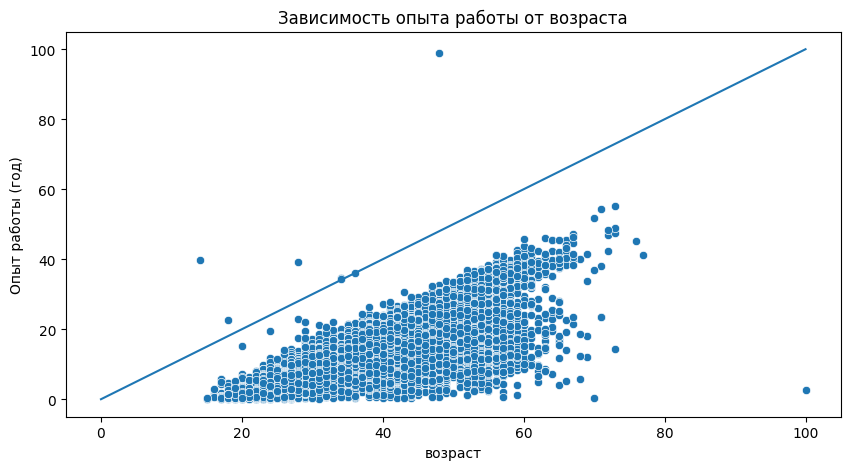

In [31]:
fig = plt.figure(figsize=(10, 5))
scatter_data = data.copy()

scatter_data['Опыт работы (год)'] = scatter_data['Опыт работы (месяц)']/12
sns.lineplot(x=[0, 100], y=[0, 100])

ax = sns.scatterplot(
    data=scatter_data, 
    x='возраст',
    y='Опыт работы (год)',
)

ax.set_title('Зависимость опыта работы от возраста');

ваши выводы здесь

График демонстрирует ожидаемую положительную зависимость между возрастом и опытом работы: с увеличением возраста увеличивается и опыт работы.
Большинство данных распределено в ожидаемом диапазоне, но встречаются аномалии, которые скорее всего являются ошибкой. 

**Дополнительные баллы**

Для получения 2 дополнительных баллов по разведывательному анализу постройте еще два любых содержательных графика или диаграммы, которые помогут проиллюстрировать влияние признаков/взаимосвязь между признаками/распределения признаков. Приведите выводы по ним. Желательно, чтобы в анализе участвовали признаки, которые мы создавали ранее в разделе "Преобразование данных".


In [22]:
# ваш код здесь

ваши выводы здесь

# Очистка данных

1. Начнем с дубликатов в наших данных. Найдите **полные дубликаты** в таблице с резюме и удалите их. 

In [33]:
duplicates = data[data.duplicated()]
data = data.drop_duplicates()

2. Займемся пропусками. Выведите информацию **о числе пропусков** в столбцах. 

In [35]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Последнее/нынешнее место работы      1
Последняя/нынешняя должность         2
Опыт работы (месяц)                168
dtype: int64


3. Итак, у нас есть пропуски в 3ех столбцах: **"Опыт работы (месяц)"**, **"Последнее/нынешнее место работы"**, **"Последняя/нынешняя должность"**. Поступим следующим образом: удалите строки, где есть пропуск в столбцах с местом работы и должностью. Пропуски в столбце с опытом работы заполните **медианным** значением.

In [38]:
data = data.dropna(subset=['Последнее/нынешнее место работы', 'Последняя/нынешняя должность'])
data['Опыт работы (месяц)'] = data['Опыт работы (месяц)'].fillna(data['Опыт работы (месяц)'].median())
print(round(data['Опыт работы (месяц)'].mean()))

114


4. Мы добрались до ликвидации выбросов. Сначала очистим данные вручную. Удалите резюме, в которых указана заработная плата либо выше 1 млн. рублей, либо ниже 1 тыс. рублей.

In [42]:
outliers = data[(data['ЗП (руб)'] > 1e6) | (data['ЗП (руб)'] < 1e3)]
data = data.drop(outliers.index)
print(outliers.shape[0])

0


5. В процессе разведывательного анализа мы обнаружили резюме, в которых **опыт работы в годах превышал возраст соискателя**. Найдите такие резюме и удалите их из данных


In [44]:
outliers = data[data['Опыт работы (месяц)'] / 12 >= data['возраст']]
data = data.drop(outliers.index)
print(outliers.shape[0])

7


6. В результате анализа мы обнаружили потенциальные выбросы в признаке **"Возраст"**. Это оказались резюме людей чересчур преклонного возраста для поиска работы. Попробуйте построить распределение признака в **логарифмическом масштабе**. Добавьте к графику линии, отображающие **среднее и границы интервала метода трех сигм**. Напомним, сделать это можно с помощью метода axvline. Например, для построение линии среднего будет иметь вид:

`histplot.axvline(log_age.mean(), color='k', lw=2)`

В какую сторону асимметрично логарифмическое распределение? Напишите об этом в комментарии к графику.
Найдите выбросы с помощью метода z-отклонения и удалите их из данных, используйте логарифмический масштаб. Давайте сделаем послабление на **1 сигму** (возьмите 4 сигмы) в **правую сторону**.

Выведите таблицу с полученными выбросами и оцените, с каким возрастом соискатели попадают под категорию выбросов?

3


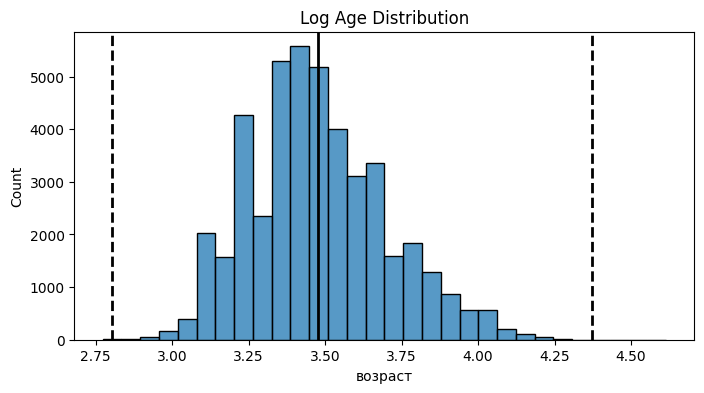

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_age = np.log(data['возраст'] + 1)
histplot = sns.histplot(log_age, bins=30, ax=ax)
histplot.axvline(log_age.mean(), color='k', lw=2)
histplot.axvline(log_age.mean()+ 4 *log_age.std(), color='k', ls='--', lw=2)
histplot.axvline(log_age.mean()- 3 *log_age.std(), color='k', ls='--', lw=2)
histplot.set_title('Log Age Distribution');

def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
outliers, cleaned_data = outliers_z_score_mod(data, 'возраст', left=3,  right=4, log_scale=True)
print(outliers.shape[0])

ваш коммментарий здесь